# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

- Help dealers to determine max - min price of car to quote.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [34]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split


#libraries for models
from sklearn.linear_model import LinearRegression


from sklearn.neighbors import KNeighborsRegressor




import warnings
warnings.filterwarnings('ignore')

In [16]:
cars = pd.read_csv('data/vehicles.csv')

In [17]:
cars.isnull().any()

id              False
region          False
price           False
year             True
manufacturer     True
model            True
condition        True
cylinders        True
fuel             True
odometer         True
title_status     True
transmission     True
VIN              True
drive            True
size             True
type             True
paint_color      True
state           False
dtype: bool

In [18]:
cars.isnull().sum()


id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [19]:
cars.describe()


id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07

In [20]:
cars.corr()

id     price      year  odometer
id        1.000000 -0.002779 -0.059040  0.010721
price    -0.002779  1.000000 -0.004925  0.010032
year     -0.059040 -0.004925  1.000000 -0.157215
odometer  0.010721  0.010032 -0.157215  1.000000

In [21]:
cars.condition.unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [22]:
cars  = cars.drop_duplicates()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [23]:
cars = cars.dropna()

In [24]:
cars = cars.query('price > 0')

In [25]:
cars.reset_index(inplace=True,drop=True)

In [26]:
cars

id      region  price    year   manufacturer            model  \
0      7316482063  birmingham   4000  2002.0         toyota             echo   
1      7316429417  birmingham   2500  1995.0            bmw             525i   
2      7315946365  birmingham   9000  2008.0          mazda       miata mx-5   
3      7315354216  birmingham   8950  2011.0           ford            f-150   
4      7315349921  birmingham   4000  1972.0  mercedes-benz             benz   
...           ...         ...    ...     ...            ...              ...   
32491  7303314912     wyoming  23495  2015.0           ford     f150 xlt 4x4   
32492  7303227528     wyoming  12995  2016.0      chevrolet         cruze lt   
32493  7303114896     wyoming  32999  2014.0           ford        f350, xlt   
32494  7303112347     wyoming  15999  2018.0      chevrolet        cruze, lt   
32495  7302338378     wyoming   6800  1997.0         jaguar  xk8 convertible   

       condition    cylinders    fuel  odometer title_status transmission  \
0      excellent  4 cylinders     gas  155000.0        clean    automatic   
1           fair  6 cylinders     gas  110661.0        clean    automatic   
2      excellent  4 cylinders     gas   56700.0        clean    automatic   
3      excellent  6 cylinders     gas  164000.0        clean    automatic   
4           fair  6 cylinders     gas   88100.0        clean    automatic   
...          ...          ...     ...       ...          ...          ...   
32491   like new  8 cylinders     gas  146795.0        clean    automatic   
32492   like new  4 cylinders     gas   61127.0        clean    automatic   
32493  excellent  8 cylinders  diesel  154642.0        clean    automatic   
32494  excellent  4 cylinders     gas   36465.0        clean    automatic   
32495       good  8 cylinders     gas   69550.0        clean    automatic   

                     VIN drive       size         type paint_color state  
0      JTDBT123520243495   fwd    compact        sedan        blue    al  
1      WBAHD6322SGK86772   rwd   mid-size        sedan       white    al  
2      JM1NC25F570128735   rwd    compact  convertible       white    al  
3      1FTMF1CM6BKD55331   fwd  full-size        truck       white    al  
4            1.14023E+13   rwd  full-size        coupe      silver    al  
...                  ...   ...        ...          ...         ...   ...  
32491  1FTFX1EF5FFC24427   4wd  full-size        truck       black    wy  
32492  1G1BE5SM0G7266569   fwd    compact        sedan      silver    wy  
32493  1FT8W3DT3EEB41548   4wd  full-size       pickup       brown    wy  
32494  1G1BE5SM7J7133704   fwd   mid-size        sedan       black    wy  
32495  SAJGX2749VCOO8376   rwd    compact  convertible       white    wy  

[32496 rows x 18 columns]

### Data Visualization & Analysis

<AxesSubplot:xlabel='decade', ylabel='count'>

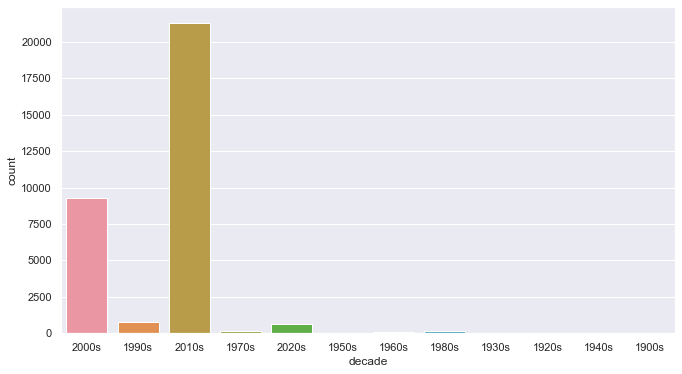

In [32]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

cars['decade'] = cars['year'].apply(get_decade)
sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(cars['decade'])

In [36]:
px.scatter(cars,x='year',y = 'price',color = 'decade')

In [37]:
px.histogram(cars,x = 'year',y = 'price',color='condition',title = 'Price Trend on Basis of Year')

In [38]:
px.histogram(cars,x = 'type',y = 'price',color='decade')

In [39]:
px.histogram(cars,x = 'manufacturer',y = 'price',color='decade')

In [40]:
cars['paint_color'].value_counts()

white     9092
black     5994
silver    4483
grey      3989
blue      3141
red       2900
custom     868
green      842
brown      748
yellow     215
orange     152
purple      72
Name: paint_color, dtype: int64

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [46]:
#defining numerical and categorical values

num_col=['year','odometer','long','lat']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']


In [62]:
## Split the data to training and test sets, 70/30 split ratio so that we can assess how well the model 
X = cars.drop(['price'], axis = 1)
y = cars.price


x = X[['year','odometer']]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [64]:
R_MSLE=[]
for i in range(1,10):
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    error=np.sqrt(mean_squared_log_error(y_test, y_pred))
    R_MSLE.append(error)
    print("K =",i," , Root MSLE =",error)

K = 1  , Root MSLE = 1.0054490151676858
K = 2  , Root MSLE = 0.9836377356177689
K = 3  , Root MSLE = 1.007299978198669
K = 4  , Root MSLE = 1.0626889765084644
K = 5  , Root MSLE = 1.1325477181544041
K = 6  , Root MSLE = 1.183333234206382
K = 7  , Root MSLE = 1.2282747121063649
K = 8  , Root MSLE = 1.246358478367504
K = 9  , Root MSLE = 1.268599988848031


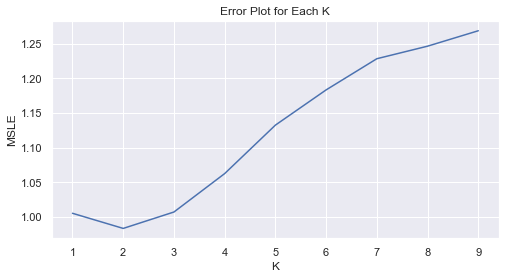

In [65]:
curve = pd.DataFrame(R_MSLE) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(1,10)), list(range(1,10)), rotation='horizontal')
plt.plot(list(range(1,10)),R_MSLE)
plt.xlabel('K')
plt.ylabel('MSLE')
plt.title('Error Plot for Each K')
plt.savefig('KNN-Error-Plot.jpg')
plt.show()

In [66]:
KNN=KNeighborsRegressor(n_neighbors=5) 
KNN.fit(X_train,y_train)
y_pred=KNN.predict(X_test)

In [70]:
#function for evaluation of model
def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])    


In [71]:
r4_knn=result(y_test,y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))
accu['KNN']=r4_knn

MSLE : 1.2826643338967476
Root MSLE : 1.1325477181544041
R2 Score : 0.41419799357196085 or 41.4198%


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.